In [ ]:
# This notebook contains three models 1) tabular(for comparision) 2) the Hybrid Model (main model cell 13 to cell 25) , 3) CNN model (for gradcam visualisation )

In [1]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Environment ready")
print("TensorFlow version:", tf.__version__)


Environment ready
TensorFlow version: 2.13.0


In [3]:
DATASET_PATH = r"train_with_images.csv" 
df = pd.read_csv(DATASET_PATH)

print("Loaded dataframe shape:", df.shape)
print("Columns:", df.columns.tolist())


print("Dataset loaded & verified")


Loaded dataframe shape: (16209, 22)
Columns: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'image_path']
Dataset loaded & verified


In [4]:
# =========================
# Target engineering
# =========================

# Guard against invalid prices
assert (df["price"] >= 0).all(), "Negative prices found"

# Log-transform target
df["log_price"] = np.log1p(df["price"])

# =========================
# Final cleanup
# =========================
df = df.dropna(subset=["image_path", "log_price"]).reset_index(drop=True)

# Safety checks
assert np.isfinite(df["log_price"]).all()
assert df["image_path"].notna().all()

print("Cell 3 executed:")
print("Final dataframe shape:", df.shape)
print(df[["price", "log_price"]].head())


Cell 3 executed:
Final dataframe shape: (16209, 23)
    price  log_price
0  268643  12.501142
1  245000  12.409018
2  200000  12.206078
3  352499  12.772806
4  232000  12.354497


In [5]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =========================
# Reproducibility
# =========================

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)


In [6]:
# =========================
# Define tabular feature columns
# =========================

TABULAR_COLUMNS = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot",
    "floors", "waterfront", "view", "condition", "grade",
    "sqft_above", "sqft_basement",
    "yr_built",
    "lat", "long",
    "sqft_living15", "sqft_lot15"
]

print("Cell 4 executed: Tabular columns verified")
print("Number of tabular features:", len(TABULAR_COLUMNS))


Cell 4 executed: Tabular columns verified
Number of tabular features: 16


In [7]:
# =========================
# Train / validation split
# =========================

from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED
)

print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)


Train shape: (12967, 23)
Validation shape: (3242, 23)


In [8]:
# =========================
# Scale tabular features
# =========================

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_tab = scaler.fit_transform(df_train[TABULAR_COLUMNS])
X_val_tab   = scaler.transform(df_val[TABULAR_COLUMNS])

# Targets (log-price)
y_train = df_train["log_price"].values.astype("float32")
y_val   = df_val["log_price"].values.astype("float32")

# Safety checks
assert np.isfinite(X_train_tab).all()
assert np.isfinite(X_val_tab).all()
assert np.isfinite(y_train).all()
assert np.isfinite(y_val).all()

print("Cell 6 executed:")
print("X_train_tab shape:", X_train_tab.shape)
print("X_val_tab shape:", X_val_tab.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


Cell 6 executed:
X_train_tab shape: (12967, 16)
X_val_tab shape: (3242, 16)
y_train shape: (12967,)
y_val shape: (3242,)


In [9]:
# =========================
# Build tabular-only baseline model
# =========================

from tensorflow.keras import layers, models

tabular_input = tf.keras.Input(
    shape=(X_train_tab.shape[1],),
    name="tabular_input",
    dtype="float32"
)

x = layers.Dense(128, activation="relu")(tabular_input)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)

output = layers.Dense(1, name="log_price")(x)

tabular_model = models.Model(
    inputs=tabular_input,
    outputs=output
)

tabular_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tabular_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 128)               2176      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 log_price (Dense)           (None, 1)                 33        
                                                                 
Total params: 12545 (49.00 KB)
Trainable params: 12545 (49.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# =========================
# Compile baseline model (SAFE)
# =========================

from tensorflow.keras.optimizers import Adam

tabular_model.compile(
    optimizer=Adam(
        learning_rate=1e-4,   # conservative for stability
        clipnorm=1.0          # prevents gradient explosion
    ),
    loss=tf.keras.losses.Huber(delta=1.0)  
)

print("Cell 8 executed: Baseline model compiled safely")


Cell 8 executed: Baseline model compiled safely


In [11]:
# =========================
# Train tabular-only baseline model
# =========================

history_tabular = tabular_model.fit(
    X_train_tab,
    y_train,
    validation_data=(X_val_tab, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=6,
            restore_best_weights=True
        )
    ],
    verbose=1
)


Epoch 1/50
406/406 [==============================] - 4s 5ms/step - loss: 7.9265 - val_loss: 2.3491
Epoch 2/50
406/406 [==============================] - 1s 3ms/step - loss: 1.5190 - val_loss: 1.0956
Epoch 3/50
406/406 [==============================] - 1s 3ms/step - loss: 0.9105 - val_loss: 0.7901
Epoch 4/50
406/406 [==============================] - 1s 3ms/step - loss: 0.6777 - val_loss: 0.5985
Epoch 5/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5072 - val_loss: 0.4642
Epoch 6/50
406/406 [==============================] - 1s 3ms/step - loss: 0.3758 - val_loss: 0.3419
Epoch 7/50
406/406 [==============================] - 1s 3ms/step - loss: 0.2800 - val_loss: 0.2612
Epoch 8/50
406/406 [==============================] - 1s 3ms/step - loss: 0.2111 - val_loss: 0.1983
Epoch 9/50
406/406 [==============================] - 1s 3ms/step - loss: 0.1627 - val_loss: 0.1621
Epoch 10/50
406/406 [==============================] - 1s 3ms/step - loss: 0.1302 - val_loss: 0.1309

In [12]:
# =========================
# Evaluate tabular-only baseline (LOG SPACE)
# =========================

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on validation data
y_val_pred = tabular_model.predict(X_val_tab).reshape(-1)

# Metrics
rmse_log = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2_log   = r2_score(y_val, y_val_pred)

print("TABULAR-ONLY RMSE (log space):", rmse_log)
print("TABULAR-ONLY R² (log space):", r2_log)


102/102 [==============================] - 0s 2ms/step
TABULAR-ONLY RMSE (log space): 0.31538195883746345
TABULAR-ONLY R² (log space): 0.6395562887191772


In [13]:
# ======================================================
# HYBRID MODEL SETUP (Tabular + Images)
# ======================================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --------------------------
# Image configuration
# --------------------------
IMG_SIZE = (224, 224)
IMG_SHAPE = (224, 224, 3)

BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

print("Hybrid model setup ready")
print("IMG_SHAPE:", IMG_SHAPE)
print("BATCH_SIZE:", BATCH_SIZE)


Hybrid model setup ready
IMG_SHAPE: (224, 224, 3)
BATCH_SIZE: 32


In [14]:
# ======================================================
# Load dataset for Hybrid model
# ======================================================

import pandas as pd
import os

DATASET_PATH = r"train_with_images.csv"

df = pd.read_csv(DATASET_PATH)

print("Dataset loaded")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# --------------------------
# Critical checks
# --------------------------
assert "image_path" in df.columns, "image_path column missing"
assert "price" in df.columns, "price column missing"

# Check image existence
missing_imgs = df[~df["image_path"].apply(os.path.exists)]
print("Missing images:", len(missing_imgs))

assert len(missing_imgs) == 0, "Some image files are missing!"


Dataset loaded
Shape: (16209, 22)
Columns: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'image_path']
Missing images: 0


In [ ]:
# ======================================================
# Define tabular features & target
# ======================================================

import numpy as np

# Tabular columns (EXACT match with preprocessing)
TABULAR_COLUMNS = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot",
    "floors", "waterfront", "view", "condition", "grade",
    "sqft_above", "sqft_basement",
    "yr_built",
    "lat", "long",
    "sqft_living15", "sqft_lot15"
]

# Sanity check
missing_cols = set(TABULAR_COLUMNS) - set(df.columns)
assert len(missing_cols) == 0, f"Missing columns: {missing_cols}"

# Target engineering
df["log_price"] = np.log1p(df["price"])

print("Target created: log_price")

# Range checks
print("PRICE range:", df["price"].min(), "→", df["price"].max())
print("LOG_PRICE range:", df["log_price"].min(), "→", df["log_price"].max())


Target created: log_price
PRICE range: 75000 → 7700000
LOG_PRICE range: 11.225256725762893 → 15.856731016694035


In [16]:
# ======================================================
# Train / Validation split
# ======================================================

from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED
)

print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)


Train shape: (12967, 23)
Validation shape: (3242, 23)


In [17]:
# ======================================================
# Scale tabular features (CRITICAL)
# ======================================================

from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()

# Fit ONLY on training data
X_train_tab = scaler.fit_transform(df_train[TABULAR_COLUMNS])
X_val_tab   = scaler.transform(df_val[TABULAR_COLUMNS])

# Targets (log space)
y_train = df_train["log_price"].values.astype("float32")
y_val   = df_val["log_price"].values.astype("float32")

# Safety checks
assert np.isfinite(X_train_tab).all()
assert np.isfinite(X_val_tab).all()
assert np.isfinite(y_train).all()
assert np.isfinite(y_val).all()

print("Tabular scaling complete")
print("X_train_tab shape:", X_train_tab.shape)
print("X_val_tab shape:", X_val_tab.shape)

Tabular scaling complete
X_train_tab shape: (12967, 16)
X_val_tab shape: (3242, 16)


In [ ]:
# ======================================================
# Image loading function
# ======================================================

IMG_SIZE = (224, 224)

def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image




Sample image shape: (224, 224, 3)
Sample image dtype: <dtype: 'float32'>


In [19]:
# ======================================================
# Build hybrid tf.data datasets (image + tabular)
# ======================================================

def make_hybrid_dataset(image_paths, tabular_data, targets, shuffle=True):
    # Ensure correct dtypes
    tabular_data = tabular_data.astype("float32")
    targets = targets.astype("float32")

    ds = tf.data.Dataset.from_tensor_slices(
        (
            {
                "image_input": image_paths,
                "tabular_input": tabular_data,
            },
            targets
        )
    )

    def _map_fn(x, y):
        x["image_input"] = load_image(x["image_input"])
        return x, y

    ds = ds.map(_map_fn, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=2048, seed=SEED)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)

    return ds


# Create datasets
train_ds = make_hybrid_dataset(
    df_train["image_path"].values,
    X_train_tab,
    y_train,
    shuffle=True
)

val_ds = make_hybrid_dataset(
    df_val["image_path"].values,
    X_val_tab,
    y_val,
    shuffle=False
)

print("Hybrid datasets created")


Hybrid datasets created


In [20]:
# ======================================================
# Build HYBRID model (Image + Tabular)
# ======================================================

# --------------------------
# Image branch (CNN)
# --------------------------
image_input = keras.Input(shape=IMG_SHAPE, name="image_input")

base_cnn = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=image_input
)

# Freeze early layers, allow deeper layers to adapt
for layer in base_cnn.layers[:-40]:
    layer.trainable = False
for layer in base_cnn.layers[-40:]:
    layer.trainable = True

x_img = base_cnn.output
x_img = layers.GlobalAveragePooling2D()(x_img)

# Strong projection head
x_img = layers.Dense(256, activation="relu")(x_img)
x_img = layers.Dense(128, activation="relu")(x_img)

# --------------------------
# Tabular branch
# --------------------------
tabular_input = keras.Input(
    shape=(X_train_tab.shape[1],),
    name="tabular_input"
)

x_tab = layers.Dense(128, activation="relu")(tabular_input)
x_tab = layers.Dense(64, activation="relu")(x_tab)

# --------------------------
# Fusion
# --------------------------
combined = layers.Concatenate()([x_img, x_tab])

combined = layers.Dense(128, activation="relu")(combined)
combined = layers.Dense(64, activation="relu")(combined)

output = layers.Dense(1, name="log_price")(combined)

hybrid_model = keras.Model(
    inputs={"image_input": image_input, "tabular_input": tabular_input},
    outputs=output
)

hybrid_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['image_input[0][0]']         
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]'] 

In [21]:
# ======================================================
# Compile HYBRID model (STABLE)
# ======================================================

hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-4,   # lower than tabular, safer for CNN
        clipnorm=1.0          # prevents gradient explosion
    ),
    loss=tf.keras.losses.Huber(delta=1.0),
    metrics=[]
)

print("Hybrid model compiled successfully")


Hybrid model compiled successfully


In [ ]:
# # ======================================================
# # HYBRID TRAINING: STAGE-1 ➜ STAGE-2 (SEQUENTIAL)
# # ======================================================

from tensorflow import keras
import os

# -----------------------------
# Common callbacks
# -----------------------------
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ======================================================
# STAGE 1 — Train fusion head (CNN frozen)
# ======================================================
# Freeze entire CNN
for layer in hybrid_model.layers:
    if "efficientnet" in layer.name.lower():
        layer.trainable = False

hybrid_model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=1e-4,
        clipnorm=1.0
    ),
    loss=keras.losses.Huber(delta=1.0)
)

stage1_ckpt = "best_hybrid_model_stage1.h5"

history_stage1 = hybrid_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[
        early_stop,
        keras.callbacks.ModelCheckpoint(
            stage1_ckpt,
            monitor="val_loss",
            save_best_only=True,
            verbose=1
        )
    ],
    verbose=1
)

print("Stage-1 completed and saved.")

# ======================================================
# STAGE 2 — Fine-tune top CNN layers
# ======================================================

print("\n==============================")
print("STAGE 2: Fine-tuning CNN")
print("==============================")

# Load best Stage-1 weights
hybrid_model = keras.models.load_model(stage1_ckpt)

# Unfreeze top CNN layers only
for layer in hybrid_model.layers:
    if "efficientnet" in layer.name.lower():
        layer.trainable = True

#freeze most CNN layers, fine-tune only last 20
cnn_layers = [
    layer for layer in hybrid_model.layers
    if "efficientnet" in layer.name.lower()
]

for layer in cnn_layers[:-20]:
    layer.trainable = False

hybrid_model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=1e-5,   # LOWER LR for fine-tuning
        clipnorm=1.0
    ),
    loss=keras.losses.Huber(delta=1.0)
)

final_ckpt = "best_hybrid_model_final.h5"

history_stage2 = hybrid_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=[
        early_stop,
        keras.callbacks.ModelCheckpoint(
            final_ckpt,
            monitor="val_loss",
            save_best_only=True,
            verbose=1
        )
    ],
    verbose=1
)

print("Stage-2 completed and final model saved.")

# ======================================================
# IF TRAINED 
# ======================================================

# import os
# from tensorflow import keras

# FINAL_MODEL_PATH = "best_hybrid_model_final.h5"

# if os.path.exists(FINAL_MODEL_PATH):
#     print("Trained hybrid model found.")
#     print("Loading model from disk (no retraining)...")
    
#     hybrid_model = keras.models.load_model(FINAL_MODEL_PATH)
#     history_stage1 = None
#     history_stage2 = None
    
#     print("Model loaded successfully.")
# else:
#     print("No trained model found.")
#     print("Training will start when training cell is run.")



Trained hybrid model found.
Loading model from disk (no retraining)...
Model loaded successfully.


In [25]:
# ======================================================
# Evaluate HYBRID model (LOG SPACE R²)
# ======================================================

import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

y_true = []
y_pred = []

for x, y in val_ds:
    preds = hybrid_model.predict(x, verbose=0).squeeze()

    y_true.append(y.numpy())
    y_pred.append(preds)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Safety checks
mask = np.isfinite(y_true) & np.isfinite(y_pred)
y_true = y_true[mask]
y_pred = y_pred[mask]

assert len(y_true) > 0, "No valid predictions"
assert np.var(y_true) > 0, "Zero variance in y_true"

rmse_log = np.sqrt(mean_squared_error(y_true, y_pred))
r2_log = r2_score(y_true, y_pred)

print("HYBRID RMSE (log space):", rmse_log)
print("HYBRID R² (log space):", r2_log)



HYBRID RMSE (log space): 0.19403730863197904
HYBRID R² (log space): 0.8635623455047607


In [ ]:
import pandas as pd
import os

# ===============================
# CSV LOCATION (ONLY INPUT HERE)
# ===============================
CSV_PATH = r"train_with_images.csv"
# Safety check
assert os.path.exists(CSV_PATH), f" CSV not found at {CSV_PATH}"

# Load CSV
df = pd.read_csv(CSV_PATH)

print(" CSV loaded successfully")
print("Rows:", len(df))
print("Columns:")
print(df.columns.tolist())


✅ CSV loaded successfully
Rows: 16209
Columns:
['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'image_path']


In [ ]:
import os

# IMAGE_ROOT is the directory where the CSV lives

IMAGE_ROOT = os.path.dirname(CSV_PATH)

print("IMAGE_ROOT set to:")
print(IMAGE_ROOT)

# Quick sanity check
print(
    "satellite_images folder exists?",
    os.path.exists(os.path.join(IMAGE_ROOT, "satellite_images"))
)


✅ IMAGE_ROOT set to:

satellite_images folder exists? True


In [ ]:
import tensorflow as tf
import numpy as np
import random

# ===============================
# GLOBAL CONFIG
# ===============================
IMG_SIZE = 224
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

# ===============================
# REPRODUCIBILITY
# ===============================
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("Global config set")
print("IMG_SIZE:", IMG_SIZE)
print("BATCH_SIZE:", BATCH_SIZE)
print("SEED:", SEED)


✅ Global config set
IMG_SIZE: 224
BATCH_SIZE: 16
SEED: 42


In [ ]:


import tensorflow as tf

def load_image(path):
    # path comes directly from CSV
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_png(img_bytes, channels=3)

    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    return img



In [30]:
# Pick one sample image path from the CSV
sample_path = df.iloc[0]["image_path"]

# Load the image
test_img = load_image(sample_path)

print("Image shape:", test_img.shape)
print(
    "Min / Max:",
    tf.reduce_min(test_img).numpy(),
    tf.reduce_max(test_img).numpy()
)


Image shape: (224, 224, 3)
Min / Max: 0.078431375 0.92961174


In [ ]:
import numpy as np

# ===============================
# CREATE LOG PRICE (SAFE)
# ===============================
df["log_price"] = np.log1p(df["price"])

print("log_price created")
print("price min / max:", df["price"].min(), df["price"].max())
print("log_price min / max:", df["log_price"].min(), df["log_price"].max())


✅ log_price created
price min / max: 75000 7700000
log_price min / max: 11.225256725762893 15.856731016694035


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED,
    shuffle=True
)

print("Train/Val split done")
print("Train rows:", len(df_train))
print("Val rows:", len(df_val))


✅ Train/Val split done
Train rows: 12967
Val rows: 3242


In [ ]:
# ===============================
# TARGET NORMALIZATION
# ===============================

mean_log_price = df_train["log_price"].mean()
std_log_price  = df_train["log_price"].std()

df_train["log_price_norm"] = (df_train["log_price"] - mean_log_price) / std_log_price
df_val["log_price_norm"]   = (df_val["log_price"] - mean_log_price) / std_log_price

print("log_price normalized")
print("Train mean (≈0):", df_train["log_price_norm"].mean())
print("Train std (≈1):", df_train["log_price_norm"].std())


✅ log_price normalized
Train mean (≈0): -1.6551201768823804e-15
Train std (≈1): 1.0


In [ ]:
# ===============================
# DATASET BUILDER
# ===============================

def make_cnn_dataset(df, training=True):
    image_paths = df["image_path"].values
    targets = df["log_price_norm"].values.astype("float32")

    ds = tf.data.Dataset.from_tensor_slices((image_paths, targets))

    def _process(path, y):
        img = load_image(path)
        return img, y

    ds = ds.map(_process, num_parallel_calls=AUTOTUNE)

    if training:
        ds = ds.shuffle(buffer_size=min(len(df), 2000), seed=SEED)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)

    return ds


train_ds = make_cnn_dataset(df_train, training=True)
val_ds   = make_cnn_dataset(df_val, training=False)

print("tf.data datasets created")


✅ tf.data datasets created


In [35]:
from tensorflow.keras import layers, models

def build_cnn_only_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)   # 112 x 112

    # Block 2 (BEST layer for Grad-CAM)
    x = layers.Conv2D(
        64, 3,
        activation="relu",
        padding="same",
        name="gradcam_conv"   # 👈 use this for Grad-CAM
    )(x)
    x = layers.MaxPooling2D(2)(x)   # 56 x 56

    # Block 3
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation="relu")(x)
    output = layers.Dense(1, activation="linear")(x)

    model = models.Model(inputs, output, name="cnn_only_gradcam_model")
    return model


cnn_model = build_cnn_only_model()
cnn_model.summary()


Model: "cnn_only_gradcam_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 gradcam_conv (Conv2D)       (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 

In [ ]:
# ===============================
# COMPILE MODEL
# ===============================

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=3e-4,   # safe for small now, scalable later
        clipnorm=1.0          # prevents gradient explosion
    ),
    loss="mse"
)

print("Model compiled successfully")


✅ Model compiled successfully


In [ ]:
import os
from tensorflow import keras

# ===============================
# TRAINING CONFIG FOR FULL DATASET
# ===============================

MODEL_PATH = "cnn_training.h5"  # use new-format saving

callbacks = [
    # Save only the best model
    keras.callbacks.ModelCheckpoint(
        filepath=MODEL_PATH,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),

    # Reduce LR when validation stalls (CRITICAL for large datasets)
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),

    # Stop if no improvement for a while
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),

    # Absolute safety
    keras.callbacks.TerminateOnNaN()
]

# ===============================
# LOAD OR TRAIN
# ===============================

if os.path.exists(MODEL_PATH):
    print("Found trained model for full dataset. Loading it...")
    cnn_model = keras.models.load_model(MODEL_PATH)

else:
    print("Training on FULL dataset")

    history = cnn_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=40,          
        callbacks=callbacks,
        verbose=1
    )

    print("Training completed and best model saved")



✅ Found trained model for full dataset. Loading it...


In [38]:
import tensorflow as tf
import numpy as np

def compute_gradcam(model, img_tensor, conv_layer_name="gradcam_conv"):
    """
    model: trained CNN-only model
    img_tensor: (1, H, W, 3)
    conv_layer_name: name of conv layer to explain
    """
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[
            model.get_layer(conv_layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, prediction = grad_model(img_tensor)
        loss = prediction[:, 0]   # regression scalar

    grads = tape.gradient(loss, conv_outputs)

    # Global average pooling on gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.nn.relu(heatmap)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy()

In [39]:
import cv2
import matplotlib.pyplot as plt

def overlay_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    img_uint8 = np.uint8(255 * img)
    overlay = cv2.addWeighted(img_uint8, 1 - alpha, heatmap, alpha, 0)
    return overlay

In [ ]:
# =========================================
# IMAGE SELECTION FOR HEATMAP ANALYSIS
# =========================================

import pandas as pd
import numpy as np

# -------------------------------
# 1. High-price vs Low-price
# -------------------------------
low_price_img = (
    df.sort_values("price", ascending=True)
      .iloc[7]["image_path"]
)

high_price_img = (
    df.sort_values("price", ascending=False)
      .iloc[33]["image_path"]
)

# -------------------------------
# 2. Same size, different price
# -------------------------------
SIZE_MIN, SIZE_MAX = 1800, 2200

same_size_df = df[
    (df["sqft_living"] >= SIZE_MIN) &
    (df["sqft_living"] <= SIZE_MAX)
]

same_size_low_price_img = (
    same_size_df.sort_values("price", ascending=True)
    .iloc[0]["image_path"]
)

same_size_high_price_img = (
    same_size_df.sort_values("price", ascending=False)
    .iloc[0]["image_path"]
)

# -------------------------------
# 3. Waterfront vs Non-Waterfront
# -------------------------------
waterfront_img = (
    df[df["waterfront"] == 1]
    .sort_values("price", ascending=False)
    .iloc[9]["image_path"]
)

non_waterfront_img = (
    df[df["waterfront"] == 0]
    .sort_values("price", ascending=False)
    .iloc[1]["image_path"]
)

# -------------------------------
# Final image set
# -------------------------------
heatmap_images = {
    "low_price": low_price_img,
    "high_price": high_price_img,
    "same_size_low_price": same_size_low_price_img,
    "same_size_high_price": same_size_high_price_img,
    "waterfront": waterfront_img,
    "non_waterfront": non_waterfront_img
}

print("Heatmap image paths selected:")
for k, v in heatmap_images.items():
    print(f"{k}: {v}")


✅ Heatmap image paths selected:
low_price: satellite_images\train\1788900230.png
high_price: satellite_images\train\3303850390.png
same_size_low_price: satellite_images\train\9133600135.png
same_size_high_price: satellite_images\train\9808700025.png
waterfront: satellite_images\train\333100295.png
non_waterfront: satellite_images\train\9208900037.png


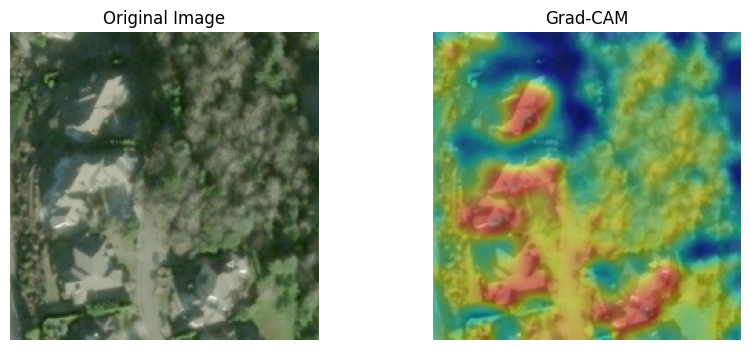

In [41]:
import cv2
import numpy as np

def smooth_heatmap(heatmap, kernel_size=15):
    heatmap = cv2.GaussianBlur(
        heatmap,
        (kernel_size, kernel_size),
        0
    )
    heatmap = heatmap / (heatmap.max() + 1e-8)
    return heatmap

# sample_path = df_val.iloc[44]["image_path"]
sample_path = heatmap_images["high_price"]

img = load_image(sample_path)
img_tensor = tf.expand_dims(img, axis=0)

# heatmap = compute_gradcam(
#     cnn_model,
#     img_tensor,
#     conv_layer_name="gradcam_conv"
# )
heatmap = compute_gradcam(cnn_model, img_tensor)
heatmap = smooth_heatmap(heatmap)


overlay = overlay_gradcam(img.numpy(), heatmap)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(overlay)
plt.axis("off")
plt.savefig("structured_housing.png", dpi=300, bbox_inches="tight")
plt.show()
